In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

from typing import List, Tuple  # For typehints

# Exercise 4.3 (4 pts)
The goal of this notebook is to gain further understanding how bias and variance are influenced by various hyperparameters.

In [4]:
def sample_sin(rng: np.random.Generator, n: int = 10):
    """
    Returns a random sample of size n with y = sin(x) + eps
    """
    X = np.sort(rng.uniform(0, 7, size=(n, 1)), axis=0)
    y = np.sin(X) + rng.normal(size=(n, 1), scale=0.5)
    return X, y

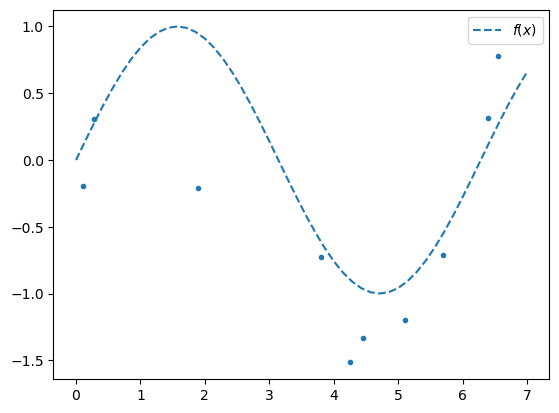

In [5]:
X, y = sample_sin(np.random.default_rng(0))
X_test = np.linspace(0, 7).reshape(-1, 1)
y_test = np.sin(X_test).reshape(-1, 1)
plt.scatter(X, y, marker=".")
plt.plot(X_test, y_test, label="$f(x)$", linestyle="dashed")
plt.legend()

## Exercise 4.3.1 (0.5pts)
Once again implement the fit methods for the `linear_regression` and `ridge_regression` models by hand.
Make sure to add a column of ones to the data matrix to model the bias.

In [64]:
class Estimator:

    def __init__(self, include_bias=True):
        self.include_bias = include_bias

    def get_design_matrix(self, X: np.ndarray):
        """
        Adds a column of ones to the input matrix to model the bias
        """
        if self.include_bias:
            dummy = np.ones((X.shape[0], 1))
            return np.hstack([X, dummy])
        else:
            return X

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fits the model using the input features X and labels y
        :param X: (N, D) numpy array, each row is one observation
        :param y: (N, 1) numpy array, one target for each observation
        """
        # Set self.w
        raise NotImplementedError

    def predict(self, X_test: np.ndarray):
        phi = self.get_design_matrix(X_test)
        return phi @ self.w


class linear_regression(Estimator):

    def fit(self, X: np.ndarray, y: np.ndarray):
        X = self.get_design_matrix(X)
        self.w = np.linalg.inv(X.T @ X) @ X.T @ y
        return self


class ridge_regression(Estimator):
    def __init__(self, lambda_: float, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda_ = lambda_

    def fit(self, X: np.ndarray, y: np.ndarray):
        X = self.get_design_matrix(X)
        self.w = np.linalg.inv(X.T @ X + self.lambda_ * np.eye(X.shape[1])) @ X.T @ y
        return self

## Exercise 4.3.2 Polynomial features & model complexity (0.5pts)

In this exercise, you will explore the impact of polynomial features on linear regression and ridge regression models and how the role of regularization controls the model complexity. Polynomial features are a form of basis expansion where instead of using just $X$ we add powers of $X$, e.g. $X^{d}, X^{d-1}, \dots X^2, X^1$,
resulting in a linear regression model with $d$ parameters:

$$
    \hat{f}(x) = w_0 + \sum_{i=1}^{d-1} w_i \cdot x^{i}
$$

This allows the model to fit non-linear relationships.

This technique allows linear models to capture more complex patterns in the data.

Complete the following function by fitting a linear regression and a ridge regression model on polynomial features for each degree.
To obtain the polynomial features you can use sklearns `PolynomialFeatures`. Note that either on `PolynomialFeatures` or the model class `include_bias` should be set to false.

For each degree, also plot the fit of both the linear and ridge regression models, as well as the true model given by $y = sin(x)$, to visually compare their performance.

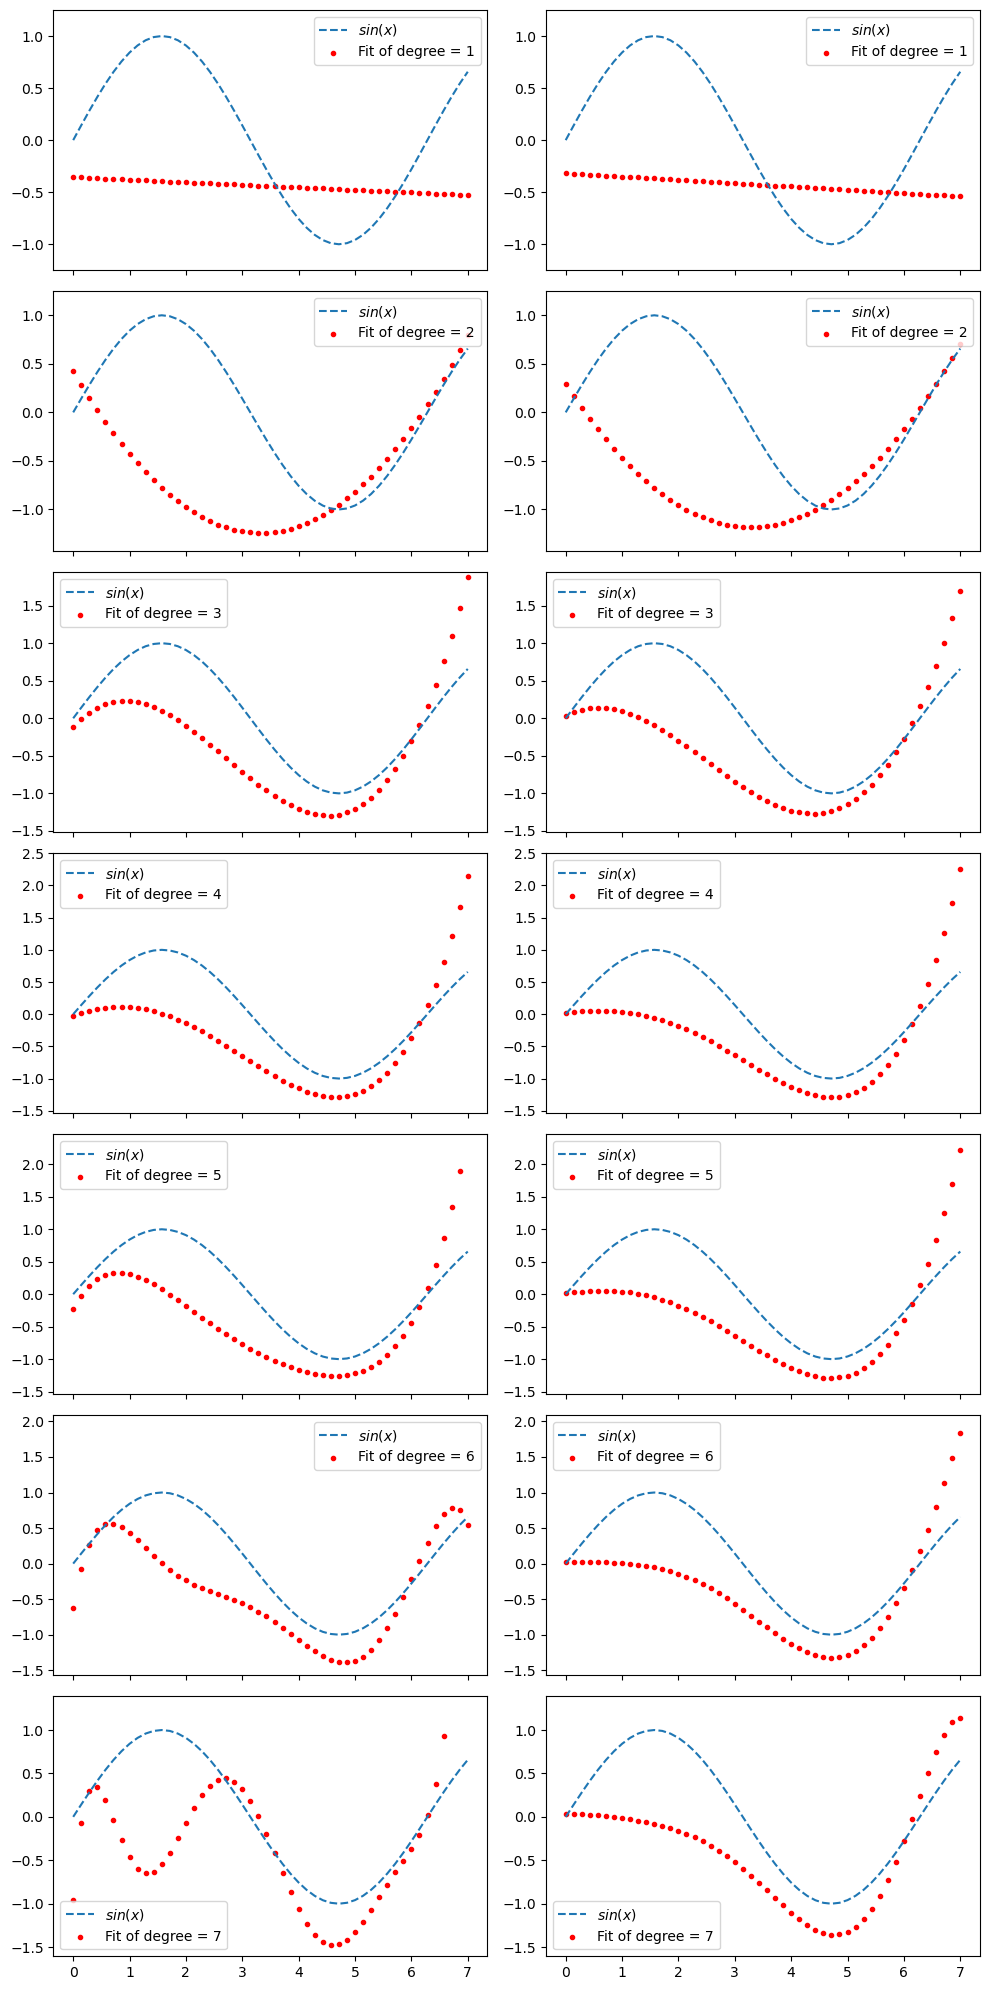

In [118]:
def compare_degree(X: np.ndarray, y: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, d: int = 7) -> None:
    """
    Plots the fit for linear and ridge regression with polynomial basis of degrees 1 to d
    E.g. for degree 2 we plot the linear/ridge regression model w_1 * X^2 + w_2 * X + w_0
    
    """
    fig, axes = plt.subplots(d, 2, sharex="all")
    fig.set_size_inches(10, 20 / 7 * d)
         
    for degree in range(1, d+1):
        if d-1 == 0:
            lr_axis = 0
            rr_axis = 1
        else:
            lr_axis = degree-1, 0
            rr_axis = degree-1, 1

        # Plot linear regression fit in first row, ridge regression in second row
        # Don't forget to transform the features and to plot the true function
        axes[lr_axis].plot(X_test, y_test, label="$sin(x)$", linestyle="dashed")
        axes[rr_axis].plot(X_test, y_test, label="$sin(x)$", linestyle="dashed")
    
        p_features = PolynomialFeatures(degree=degree, include_bias=False)
        lr = linear_regression()
        lr.fit(p_features.fit_transform(X), y)
        y_pred = lr.predict(p_features.fit_transform(X_test))

        axes[lr_axis].scatter(X_test, y_pred, marker='.', color='r', label=f'Fit of degree = {degree}')

        rr = ridge_regression(lambda_=0.3)
        rr.fit(p_features.fit_transform(X), y)
        y_pred = rr.predict(p_features.fit_transform(X_test))

        axes[rr_axis].scatter(X_test, y_pred, marker='.', color='r', label=f'Fit of degree = {degree}')

        axes[lr_axis].legend(loc='best')
        axes[rr_axis].legend(loc='best')
        
        axes[lr_axis].set_ylim([np.append(y_pred, y_test).min() - 0.25,
                                np.append(y_test, y_pred).max() + 0.25])
        axes[rr_axis].set_ylim([np.append(y_pred, y_test).min() - 0.25,
                                np.append(y_test, y_pred).max() + 0.25])

    fig.tight_layout()

compare_degree(X, y, X_test, y_test, d = 7)

## Exercise 4.3.3 Cross validation (0.5 + 0.5)
In the lecture you have seen how cross validation can be used to find the "best" hyperparameters of a model.
In this exercise you will implement leave-one-out cross validation for the ridge regression model.

Leave-one-out cross validation (LOOCV) is a special case of $k$-fold cross validation with $k=N$, i.e. the number of datapoints.
In LOOCV, we hold out each datapoint once and fit the model on the $N-1$ left over datapoints. The test error is then calculated on the held out datapoint.

Implement `loocv` and complete the `select_best_params` function to find the best degree, $\lambda$ combination in terms of generalization error.

In [119]:
def loocv(X: np.ndarray, y: np.ndarray, degree=1, lambda_=1.0) -> float:
    """
    Estimate the generalization error by averaging the squared error of N ridge regression models each fitted on N-1 datapoints.
    For each model the error is calculated on the left out datapoint.
    """
    N = X.shape[0]
    p_features = PolynomialFeatures(degree=degree, include_bias=False)
    error = 0
    for i in range(N):
        subset_X = np.delete(X, i, axis=0) # Leave out i-th datapoint
        subset_y = np.delete(y, i, axis=0)
        rr = ridge_regression(lambda_=lambda_)
        rr.fit(p_features.fit_transform(subset_X), subset_y)

        # Calculate the error on the left-out i-th datapoint
        y_pred = rr.predict(p_features.fit_transform(np.array(X[i]).reshape(1, -1)))
        error += (y_pred - y[i])**2

    error = 1 / N * error
    return error

In [112]:
def select_best_params(X, y) -> Tuple[ridge_regression, PolynomialFeatures]:
    """
    Selects the best degree/lambda combination using LOOCV.

    :returns: A ridge regression model with the best regulariztation strength lambda and a PolyinomialFeatures instance
        with the best degree.
    """
    degrees = list(range(1, 7))
    lambdas = [0.01, 0.1, 0.5, 1, 2]

    # Find the best degree, lambda combination by testing all possible configurations and
    # selecting the one with the lowest loocv error
    best_params = None
    min_error = -1
    for degree in degrees:
        for lambda_ in lambdas:
            error = loocv(X, y, degree=degree, lambda_=lambda_)
            if min_error == -1 or min_error > error:
                best_params = degree, lambda_
                min_error = error

    best_degree, best_lambda = best_params
    poly_transformer = PolynomialFeatures(degree=best_degree, include_bias=False)
    model = ridge_regression(lambda_=best_lambda)
    return model, poly_transformer

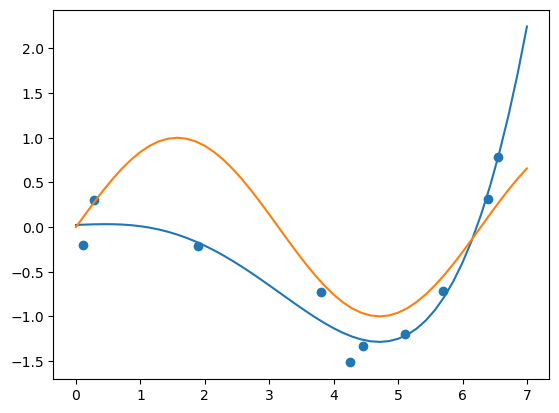

In [120]:
model, feature_transformer = select_best_params(X, y)
model.fit(feature_transformer.fit_transform(X), y)
plt.plot(X_test, model.predict(feature_transformer.fit_transform(X_test)))
plt.plot(X_test, y_test)
plt.scatter(X, y)

## Exercise 4.3.4 Model variance (0.5pts)
In this part we will explore how much a model changes based on the dataset, i.e. the variance of the model.

You are given a sample function that returns a random dataset of size $n$ with $y = 3*x + eps$.

Explore the variance of simple linear regression and ridge regression by sampling 5 datasets and plotting the model fit, as well as the ground truth function.

In [ ]:
def sample(rng, n: int = 10) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns a random sample of size n with y = 3*x + eps
    """
    X = rng.uniform(0, 7, size=(n,1))
    y = 3*X + rng.normal(size=(n, 1), scale=10)
    return X, y

In [ ]:
def variance_effect(lambda_: float) -> None:
    """
    Plots the model variance of linear and ridge regression models

    :param lambda_: Regularization strength
    """
    X_test = np.linspace(0, 7).reshape(-1, 1)
    y_test = 3*X_test
    rng = np.random.default_rng(0)
    # One ax for each dataset
    fig, axes = plt.subplots(1, 5, sharex="all", sharey="all")
    fig.set_size_inches(15, 5)

    # Sample 5 datasets, fit linear and ridge regression model for each and plot the fit versus the true function
    # It is enlighting to also plot the dataset.
    # Your code here ...

In [ ]:
# You are encouraged to play around with lambda to see how this influences the variability of the ridge regression model
variance_effect(lambda_ = 10.0)

## Exercise 4.3.5 Dataset size influence on bias and variance (1 + 0.5)

Assuming all datasets of size $n$ are equally likely, we can approximate the expected weights $\mathbb{E}[(\hat{w_0}, \hat{w_1})^T]$ by **averaging** the weights of a large number of models.
Furthermore, as long as the true process $f(x) = w_1 \cdot x + w_0$ is linear, the least squares estimate is unbiased, that is $\mathbb{E}_{D_n \sim P(X)} [(\hat{w}_0, \hat{w_1})^T] = (w_0, w_1)^T$. Use those facts to calculate bias and variance estimates of a simple model with $f(x) = 3x$.
As a reminder the variance of the model is defined as $Var(\mathbf{\hat{w}}) = \mathbb{E}[(\mathbf{\hat{w}} - \mathbb{E}[\mathbf{\hat{w}}])^2]$

Also complete the `plot_bias_variance` function to showcase the effect of the dataset on bias and variance visually.

In [ ]:
def bias_variance(n: int, rng: np.random.Generator, n_samples=10_000) -> Tuple[float, float]:
    """
    Calculates bias and variance of the linea regression parameter for datasets of size n
    for the simple case where f(x) = 3*x

    Bias is defined as w - E[w] and variance is given by E[(w - E[w])**2]
    
    :param n: Size of the datatsets
    :param rng: numpy random number generator for reproducability
    :param n_samples: Number of samples to estimate the expected value. Should be quite high for an accurate representation
    :return: Tuple with bias and variance of the model parameters
    """
    # To estimate the expectations draw n_samples datasets of size n and approximate by averaging
    # Your code here ...
    
    return bias, variance

In [ ]:
def plot_bias_variance(sizes: List[int]):
    """
    Plots the bias and variance for different dataset sizes

    :param sizes: List of dataset sizes
    """
    rng = np.random.default_rng(0)
    bias_results = []
    variance_results = []
    # Calculate bias and variances for all sizes
    # Your code here ...
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey="all")
    ticks = range(len(sizes))
    # Plot variance
    ax1.plot(ticks, variance_results)
    ax1.set_xticks(ticks, labels=sizes)
    ax1.set_xlabel("Dataset size")
    ax1.set_ylabel("Variance")

    # Plot bias
    ax2.plot(ticks, bias_results)
    ax2.set_xticks(ticks, labels=sizes)
    ax2.set_xlabel("Dataset size")
    ax2.set_ylabel("Bias")
    fig.tight_layout()

In [ ]:
plot_bias_variance([5, 6, 7, 8, 9, 10, 20, 30])